In [97]:
from transformers import CLIPProcessor, CLIPModel

# load pretrained model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# load preprocessor for model input
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /openai/clip-vit-base-patch32/resolve/main/config.json (Caused by ProxyError('Cannot connect to proxy.', NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000028572DADA60>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')))' thrown while requesting HEAD https://huggingface.co/openai/clip-vit-base-patch32/resolve/main/config.json
[ WARNING ]  'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /openai/clip-vit-base-patch32/resolve/main/config.json (Caused by ProxyError('Cannot connect to proxy.', NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000028572DADA60>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')))' thrown while requesting HEAD https://huggingface.co/openai/clip-vit-base-patch32/resolve/main/config.json


ProxyError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /openai/clip-vit-base-patch32/resolve/main/config.json (Caused by ProxyError('Cannot connect to proxy.', NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000028572DADA60>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')))

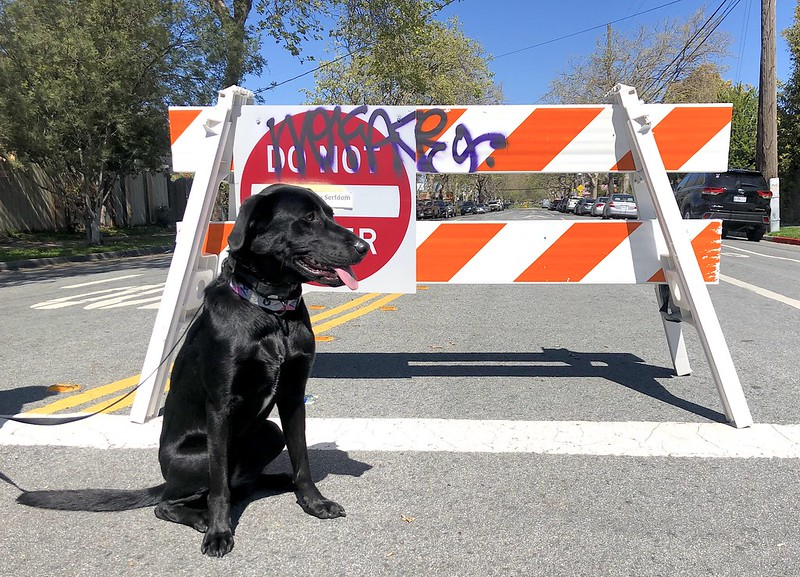

Predicted label: dog, probability score 0.9729195833206177


In [ ]:
from PIL import Image

image = Image.open('../101-tensorflow-to-openvino/data/coco.jpg')
input_labels = ['cat', 'dog', 'wolf', 'tiger', 'man', 'horse', 'frog', 'tree', 'hause', 'computer']
text_descriptions = [f"This is a photo of a {label}" for label in input_labels]

inputs = processor(text=text_descriptions, images=image, return_tensors="pt", padding=True)

results = model(**inputs)
logits_per_image = results['logits_per_image'] # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

predicted_label = probs.argmax(dim=1).item()

display(image)
print(f'Predicted label: {input_labels[predicted_label]}, probability score {probs[0][predicted_label]}')


In [ ]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

In [ ]:
!python -m transformers.onnx -m openai/clip-vit-base-patch32 clip-vit-base-patch32

& was unexpected at this time.


In [ ]:
from openvino.runtime import serialize
from openvino.tools import mo

ov_model = mo.convert_model('clip-vit-base-patch32/model.onnx')
serialize(ov_model, 'clip-vit-base-patch32.xml')

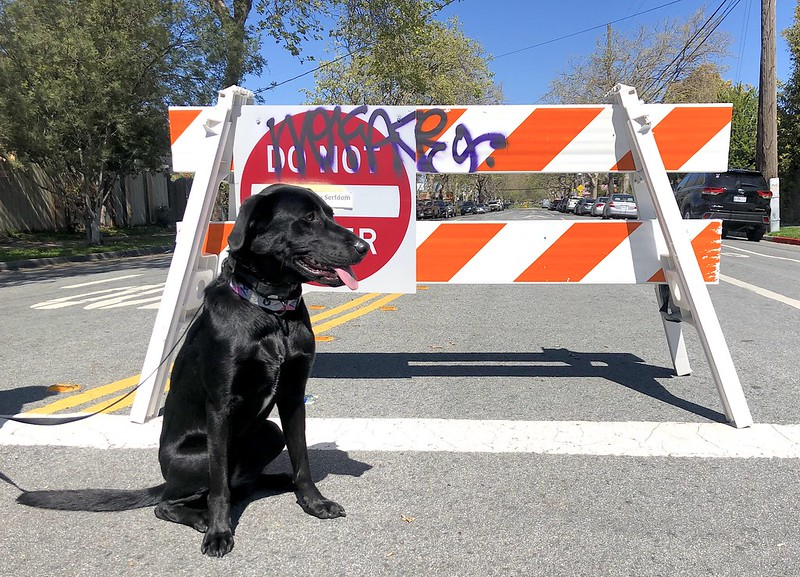

Predicted label: dog, probability score 0.9729190468788147


In [ ]:
import numpy as np
from scipy.special import softmax
from openvino.runtime import Core

core = Core()
compiled_model = core.compile_model(ov_model)
logits_per_image_out = compiled_model.output(0)

ov_logits_per_image = compiled_model(dict(inputs))[logits_per_image_out]
probs = softmax(ov_logits_per_image, axis=1)
predicted_label = np.argmax(probs, axis=1)[0]
display(image)
print(f'Predicted label: {input_labels[predicted_label]}, probability score {probs[0][predicted_label]}')

In [ ]:
from torchvision.datasets import CIFAR100

dataset = CIFAR100('data', train=False, download=True)
text_descriptions = [f"This is a photo of a {label}" for label in dataset.classes]
labels_encoded = dict(processor(text_descriptions, return_tensors='np', padding=True))

Files already downloaded and verified


In [ ]:
class DataLoader:
    def __init__(self, encoded_labels, images_dataset, preprocesor, num_samples=None):
        self.encoded_labels = encoded_labels
        self.images_dataset = images_dataset
        self.preprocessor = preprocesor
        self.num_samples = num_samples
        self.classes = self.images_dataset.classes
    
    def orig_image(self, i):
        return self.images_dataset[i][0]

    def __getitem__(self, i):
        if self.num_samples is not None and i > self.num_samples:
            raise StopIteration
        image, label = self.images_dataset[i]
        data_batch = dict(self.preprocessor(images=[image], return_tensors='np'))
        data_batch.update(self.encoded_labels)
        return data_batch, label

    def __len__(self):
        return len(self.images_dataset) if self.num_samples is None else min(self.num_samples, len(self.images_dataset))

In [ ]:
clip_dataset = DataLoader(labels_encoded, dataset, processor, 500)

In [ ]:
import matplotlib.pyplot as plt

def test_on_images(model, dataset, num_samples=8):
    plt.figure(figsize=(16, 16))
    output_layer = model.output(0)
    for i in range(num_samples):
        input_dict, _ = dataset[i]
        image = dataset.orig_image(i)
        logits = compiled_model(input_dict)[output_layer][0]
        probs = softmax(logits)
        top_5 = np.argsort(-probs)[:5]
        top_probs = probs[top_5]
        plt.subplot(4, 4, 2 * i + 1)
        plt.imshow(image)
        plt.axis("off")

        plt.subplot(4, 4, 2 * i + 2)
        y = np.arange(top_probs.shape[-1])
        plt.grid()
        plt.barh(y, top_probs)
        plt.gca().invert_yaxis()
        plt.gca().set_axisbelow(True)
        plt.yticks(y, [dataset.classes[index] for index in top_5])
        plt.xlabel("probability")

    plt.subplots_adjust(wspace=0.5)
    plt.show()

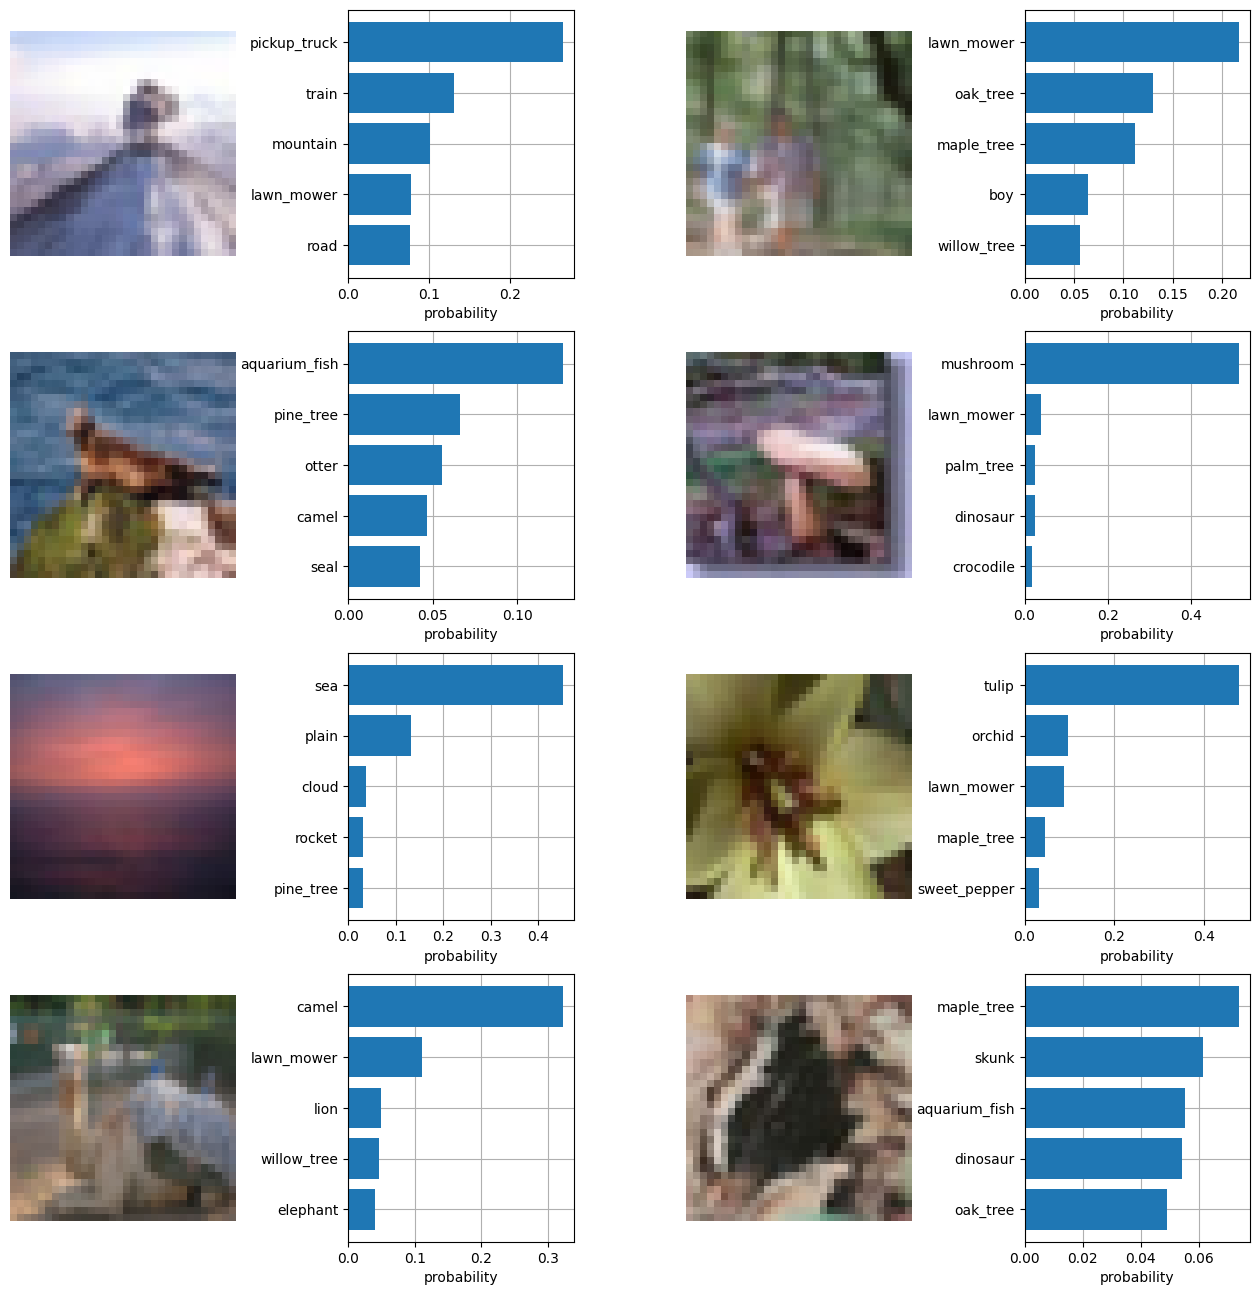

In [ ]:
test_on_images(compiled_model, clip_dataset)

In [ ]:
from tqdm.notebook import tqdm


def validate_model(model, val_dataset):
    top1, top5 = 0, 0
    output_layer = model.output(0)
    for input_data, label in tqdm(val_dataset):
        scores = model(input_data)[output_layer][0]
        top5_labels = np.argsort(-scores)[:5]
        top5 += int(label in top5_labels)
        top1 += int(label == top5_labels[0])
    return top1 / len(val_dataset), top5 / len(val_dataset)

In [ ]:
top1_acc, top5_acc = validate_model(compiled_model, clip_dataset)
print(f'Accuracy Top-1 {top1_acc * 100} %')
print(f'Accuracy Top-5 {top5_acc * 100} %')

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy Top-1 59.599999999999994 %
Accuracy Top-5 83.0 %


In [ ]:
import nncf

def transform_fn(data_item):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Tuple with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    return data_item[0]


quantization_dataset = nncf.Dataset(clip_dataset, transform_fn)

ModuleNotFoundError: No module named 'nncf'

In [ ]:
quantized_model = nncf.quantize(ov_model, quantization_dataset, model_type=nncf.arameters.ModelType.TRANSFORMER, subset_size=50)

serialize(quantized_model, 'clip-vit-base-patch32-int8.xml')

In [ ]:
compiled_model_int8 = core.compile_model(quantized_model)
test_on_images(compiled_model_int8, clip_dataset)

In [ ]:
top1_acc, top5_acc = validate_model(compiled_model_int8, clip_dataset)
print(f'Accuracy Top-1 {top1_acc * 100} %')
print(f'Accuracy Top-5 {top5_acc * 100} %')

In [ ]:
# Inference FP32 model (OpenVINO IR)
!benchmark_app -m clip-vit-base-patch32.xml  -d CPU -api async

In [ ]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m clip-vit-base-patch32-int8.xml  -d CPU -api async